In [168]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

SWDA_DIALOG_ACT_TO_TAG = {
    "Statement-non-opinion": "sd",
    "Acknowledge-Backchannel": "b",
    "Statement-opinion": "sv",
    "Agree-Accept": "aa",
    "Abandoned-or-Turn-Exit": "%",
    "Appreciation": "ba",
    "Yes-No-Question": "qy",
    "Non-verbal": "x",
    "Yes-answers": "ny",
    "Conventional-closing": "fc",
    "Uninterpretable": "%",
    "Wh-Question": "qw",
    "No-answers": "nn",
    "Response-Acknowledgement": "bk",
    "Hedge": "h",
    "Declarative-Yes-No-Question": "qy^d",
    # Replace: "Other": "fo_o_fw_by_bc" with the following as it appears like that in SWDA
    "Other": 'fo_o_fw_"_by_bc',
    "Backchannel-in-question-form": "bh",
    "Quotation": "^q",
    "Summarize/reformulate": "bf",
    "Affirmative-non-yes-answers": "na",
    "Action-directive": "ad",
    "Collaborative-Completion": "^2",
    "Repeat-phrase": "b^m",
    "Open-Question": "qo",
    "Rhetorical-Questions": "qh",
    "Hold-before-answer-agreement": "^h",
    "Reject": "ar",
    "Negative-non-no-answers": "ng",
    "Signal-non-understanding": "br",
    "Other-answers": "no",
    "Conventional-opening": "fp",
    "Or-Clause": "qrr",
    "Dispreferred-answers": "arp_nd",
    "3rd-party-talk": "t3",
    "Offers-Options-Commits": "oo_co_cc",
    "Self-talk": "t1",
    "Downplayer": "bd",
    "Maybe-Accept-part": "aap_am",
    "Tag-Question": "^g",
    "Declarative-Wh-Question": "qw^d",
    "Apology": "fa",
    "Thanking": "ft",
    "+": "+"
}

In [70]:
df = pd.read_csv("das_sv.csv")
df = df.loc[:,["session","task","da","flow_naturally_yes","hard_time_understanding_each_other_no","conversation_awkward_no"]]
df

,session,task,da,flow_naturally_yes,hard_time_understanding_each_other_no,conversation_awkward_no
0,1,1,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",5,5,5
1,1,2,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",4,5,3
2,1,3,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",4,5,5
3,1,4,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",4,5,4
4,1,5,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc fo_o_fw_""_b...",3,4,4
...,...,...,...,...,...,...
163,12,10,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",5,3,5
164,12,11,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",3,1,2
165,12,12,"sd fo_o_fw_""_by_bc fo_o_fw_""_by_bc I- I- I- I-...",4,3,4
166,12,13,"sd I- ba ba fo_o_fw_""_by_bc I- I- I- I- I- I- ...",3,2,2


In [173]:
def normalize(seq):
    seq = " ".join(seq.split(" ")[1:-1])
    
    da_pat = r'[_"\w%\^\d\+]+'
    seq = re.sub(r'(I- )+' + "(" + da_pat + ")",r"\2",seq)
    seq = re.sub(r"({}) \1+".format(da_pat),r"\1",seq)
    return seq

df = pd.read_csv("das_sv.csv")
df = df.loc[:,["session","task","da","flow_naturally_yes","hard_time_understanding_each_other_no","conversation_awkward_no"]]
df["da"] = df["da"].apply(normalize)

vec = TfidfVectorizer(
# vec = CountVectorizer(
    lowercase=True,
    tokenizer=lambda x: x.split(" "),
    ngram_range=(1,1)
)
X = vec.fit_transform(df["da"]).toarray()
for k, idx in vec.vocabulary_.items():
    df[k] = X[:,idx]
    
df.corr()["hard_time_understanding_each_other_no"].sort_values(ascending=False,key=lambda x: abs(x)).head(50)

hard_time_understanding_each_other_no    1.000000
conversation_awkward_no                  0.492211
flow_naturally_yes                       0.306417
qw                                      -0.260120
nn                                      -0.253887
fo_o_fw_"_by_bc                          0.221926
bk                                      -0.220750
fc                                      -0.210437
x                                       -0.210437
bh                                      -0.190330
%                                       -0.188800
h                                       -0.163231
far                                     -0.151808
aad                                     -0.151808
ft                                      -0.151808
qy                                      -0.148431
o                                       -0.140521
sd                                       0.136571
ar                                      -0.135491
qo                                      -0.131115


In [176]:
def observed_over_expected(df):
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    oe = df / expected
    return oe

def pmi(df, positive=True):
    df = observed_over_expected(df)
    # Silence distracting warnings about log(0):
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  # log(0) = 0
    if positive:
        df[df < 0] = 0.0
    return df
    
df_hard = df.groupby("hard_time_understanding_each_other_no").sum().iloc[:,4:]
df_hard = pmi(df_hard,positive=False)
df_hard

,"fo_o_fw_""_by_bc",sd,%,o,b,i-,bf,aa,^2,ba,...,qrr,br,ft,aad,x,fc,h,bd,far,no
hard_time_understanding_each_other_no,,,,,,,,,,,,,,,,,,,,,
0,-1.466002,-0.022459,0.034215,0.041506,-0.021375,0.000000,0.000000,-0.691927,-0.268787,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.965958,3.965958,0.000000,0.00000,0.000000,0.000000
1,-1.096028,-0.254738,-0.078789,-0.035946,-0.126452,0.000000,-1.003987,-0.320900,-0.515274,0.050820,...,0.000000,1.674254,2.799469,2.799469,0.000000,0.000000,2.069498,0.00000,2.799469,0.000000
2,-0.369459,-0.021584,0.103311,-0.048535,-0.099347,-0.046069,1.109570,0.004505,-0.062120,0.176626,...,0.249657,0.000000,0.000000,0.000000,0.000000,0.000000,0.002808,1.84347,0.000000,0.000000
3,-0.499996,-0.136883,0.053436,0.047323,0.059685,-1.759978,0.319895,0.551249,-1.251389,-1.735490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.110064,0.00000,0.000000,1.598808
4,0.023699,0.028036,0.080779,0.028821,0.004182,0.118339,-1.754449,-0.437868,0.050250,0.721626,...,0.000000,-1.274025,0.000000,0.000000,0.000000,0.000000,-0.327792,0.00000,0.000000,0.000000
5,0.450124,0.109961,-0.156275,-0.026565,0.028800,0.539157,-0.570667,-0.120507,0.434651,-0.434386,...,0.936550,0.663099,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


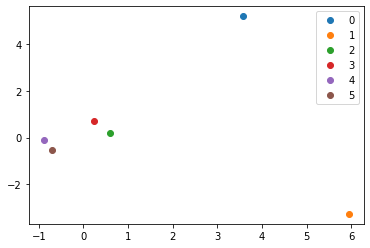

In [177]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()
X = svd.fit_transform(df_hard.values)
fig, ax = plt.subplots()
for i in range(6):
    ax.plot(X[i,0],X[i,1],'o',label=str(i))

ax.legend()

<AxesSubplot:xlabel='fa', ylabel='hard_time_understanding_each_other_no'>

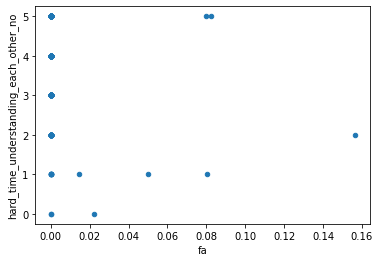

In [144]:
df.plot.scatter(y="hard_time_understanding_each_other_no",x="fa",c=)

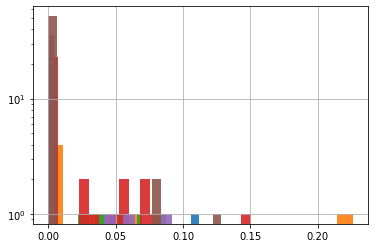

In [133]:
axs = df.groupby("hard_time_understanding_each_other_no")["o nn"].hist(bins=20,alpha=0.9)
for ax in axs:
    ax.set_yscale("log")

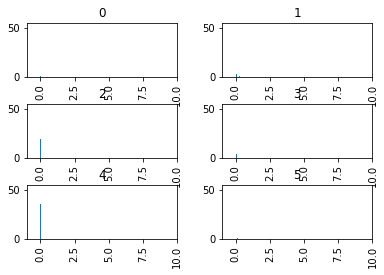

In [134]:
axes = df["nn"].hist(by=df["hard_time_understanding_each_other_no"])
for i in range(3):
    for j in range(2):
        axes[i,j].set_ylim(0,55)
        axes[i,j].set_xlim(-1,10)
    

In [139]:
for i, row in df.loc[df["hard_time_understanding_each_other_no"] >= 3,["da","o nn"]].iterrows():
    print(row["o nn"])
    print(row["da"])
    print()

0.0
fo_o_fw_"_by_bc sd % sd O sd O sd O b O sd

0.0
fo_o_fw_"_by_bc sd sd

0.0
fo_o_fw_"_by_bc O % O sd % O sd O b

0.0
fo_o_fw_"_by_bc sd % fo_o_fw_"_by_bc

0.0
fo_o_fw_"_by_bc fo_o_fw_"_by_bc fo_o_fw_"_by_bc sd

0.0
fo_o_fw_"_by_bc sd sd sd

0.0
fo_o_fw_"_by_bc sd fo_o_fw_"_by_bc sd

0.0
fo_o_fw_"_by_bc fo_o_fw_"_by_bc O fo_o_fw_"_by_bc sd sd O b O sd I-

0.0
fo_o_fw_"_by_bc sd sd O % O % sd

0.0
fo_o_fw_"_by_bc sd % sd O % O sd

0.0
fo_o_fw_"_by_bc sd sd O sd b O b % sd O b O % sd sd % O b O sd O b sd sd O % O % O sd sd O b ad fo_o_fw_"_by_bc sd

0.0
fo_o_fw_"_by_bc sd O % O ad sd O b O ad sd O % O aa sd O % qy O ny % sd

0.0
fo_o_fw_"_by_bc ad % O sd % O b sd

0.029345249366387303
fo_o_fw_"_by_bc sd sd sd sd O b O % O b O sd sd O b % O % O sd nn ar % O % b O % O b O sd O b % sd sd sd O qw O % O sd qw qw O sd sd % O b O sd O b O sd sd sd O sd O qy qw O % sd sd O ny sd sd O qy^d % O % qw O sd O nn O sd O % O b O % O b O sd sd % O bk b O % O % O sd sd O b qy qy O sd O b b % O b O sd O

<AxesSubplot:xlabel='o ny', ylabel='o nn'>

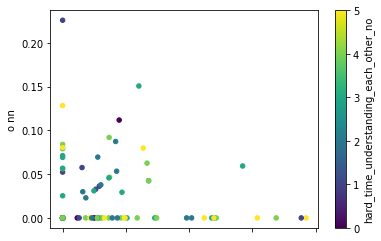

In [143]:
df.plot.scatter(x="o ny",y="o nn",c="hard_time_understanding_each_other_no",colormap="viridis")